In [1]:
from sim import Simulator, SimConfig
from miners.repay_proportional import RepayProportionalShortfallMinerState
from miners.burn import BurnShortfallMinerState
from miners.repay_ratchet import RepayRatchetShortfallMinerState
from network import *
from strategy import *
from consts import *

import dataclasses
import matplotlib.pyplot as plt
import pandas as pd

network = dataclasses.replace(MAINNET_FEB_2023, token_lease_fee=0.20)
epochs = 3 * YEAR + 1
stats_interval = DAY

In [2]:
def show_miner_accounting_charts(df):
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(13.4, 4.8))

    # Balance sheet
    ax1.grid(axis='y', color='#EEE')
    ax1.plot(df['day'], df['net_equity'], label="Net equity")
    ax1.plot(df['day'], df['balance'], label="Balance")
    ax1.plot(df['day'], df['available'], '--', label="Available")
    ax1.plot(df['day'], -df['lease'], label="Lease")
    ax1.plot(df['day'], df['pledge_locked'], '--', label="Pledge locked")
    ax1.set_title("Miner equity")
    ax1.set_xlabel("Day")
    ax1.set_ylabel("FIL")
    ax1.legend()

    # PnL
    ax2.grid(axis='y', color='#EEE')
    ax2.plot(df['day'], df['reward_earned'], label="Rewards")
    ax2.plot(df['day'], -df['fee_burned'], label="Shortfall fee")
    ax2.plot(df['day'], -df['lease_fee_accrued'], label="Lease fee")
    ax2.set_title("Miner cash flow")
    ax2.set_xlabel("Day")
    ax2.legend()

    plt.show()

def compare_configurations(cfgs, title):
    statss = {label: pd.DataFrame(Simulator(cfg).run_all(epochs, stats_interval)) for (label, cfg) in cfgs.items()}

    plt.grid(axis='y', color='#EEE')
    for label, df in statss.items():
        plt.plot(df['day'], df['net_equity'], label=label)

    plt.plot()
    plt.title("Miner equity - " + title)
    plt.xlabel("Day")
    plt.ylabel("FIL")
    plt.legend()
    plt.show()

## Repay the shortfall

In [3]:
cfg = SimConfig(
    network=network,
    strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
    miner_factory=RepayRatchetShortfallMinerState.factory(balance=0),
)
stats = Simulator(cfg).run_all(epochs, stats_interval)
repay_shortfall_df = pd.DataFrame(data=stats)
repay_shortfall_df

,day,epoch,power,balance,lease,pledge_locked,available,net_equity,reward_earned,fee_burned,lease_fee_accrued,pledge_required,shortfall,shortfall_pct
0,0,1,331262237605888,1000.0000,1000.0002,1000.0000,0.0000,-0.0002,0.0000,0.0000,0.0002,2099.5805,1099.5805,52.37
1,1,2881,331262237605888,1003.0121,1000.5469,1003.0121,0.0000,2.4652,4.0163,1.0028,0.5483,2099.5805,1096.5684,52.23
2,2,5761,331262237605888,1006.0232,1001.0914,1006.0232,0.0000,4.9318,8.0313,2.0029,1.0967,2099.5805,1093.5573,52.08
3,3,8641,331262237605888,1009.0334,1001.6339,1009.0334,0.0000,7.3995,12.0450,3.0002,1.6454,2099.5805,1090.5471,51.94
4,4,11521,331262237605888,1012.0426,1002.1741,1012.0426,0.0000,9.8684,16.0575,3.9947,2.1944,2099.5805,1087.5379,51.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,1091,3142081,331262237605888,3192.7859,0.0000,2099.5805,1093.2055,3192.7859,3705.8766,190.7590,322.3317,2099.5805,0.0000,0.00
1092,1092,3144961,331262237605888,3195.6295,0.0000,2099.5805,1096.0490,3195.6295,3708.7202,190.7590,322.3317,2099.5805,0.0000,0.00
1093,1093,3147841,331262237605888,3198.4721,0.0000,2099.5805,1098.8916,3198.4721,3711.5628,190.7590,322.3317,2099.5805,0.0000,0.00
1094,1094,3150721,331262237605888,3201.3138,0.0000,2099.5805,1101.7334,3201.3138,3714.4046,190.7590,322.3317,2099.5805,0.0000,0.00


<Figure size 640x480 with 0 Axes>

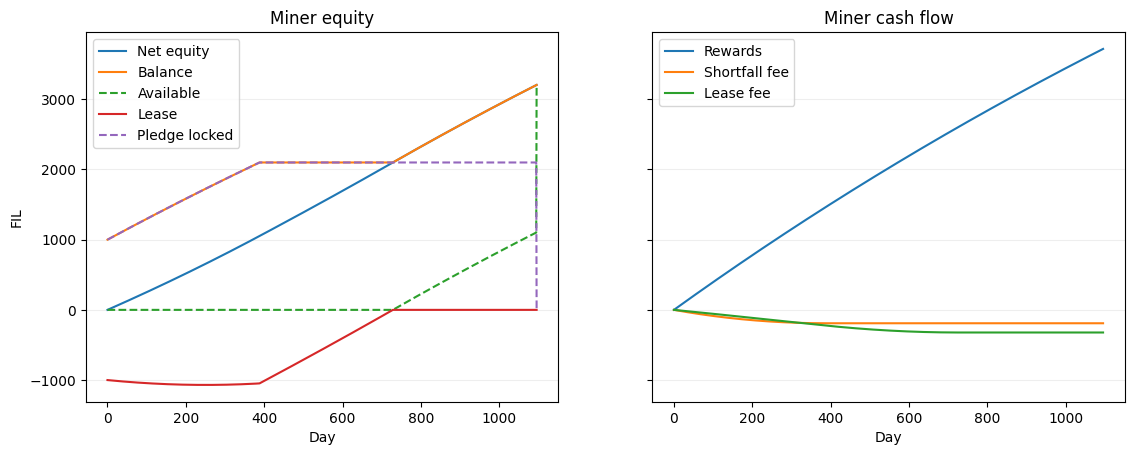

In [4]:
show_miner_accounting_charts(repay_shortfall_df)

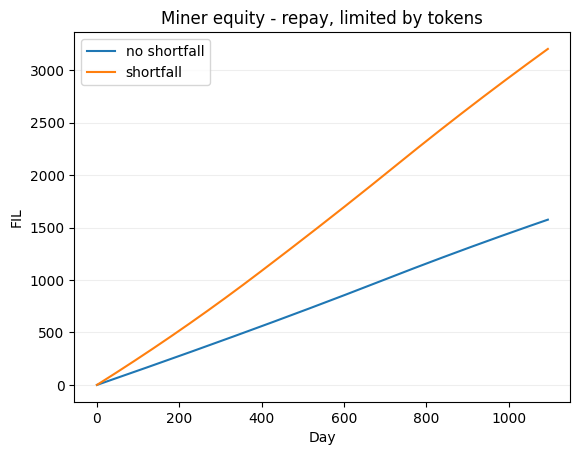

In [5]:
# Configurations limited by token availability.
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, False),
        miner_factory=RepayRatchetShortfallMinerState.factory(balance=0),
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
        miner_factory=RepayRatchetShortfallMinerState.factory(balance=0),
    )
}, 'repay, limited by tokens')

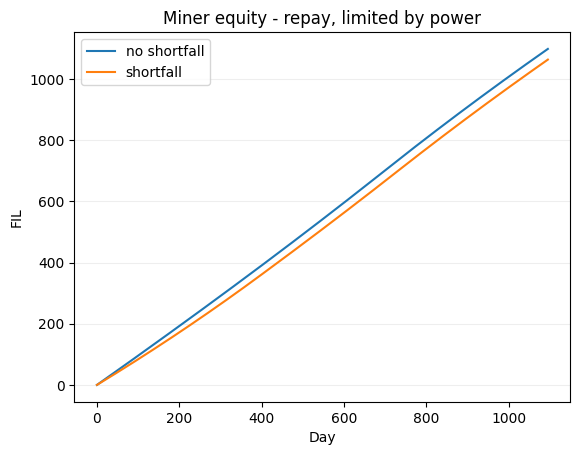

In [6]:
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100*TIBIBYTE, 3*YEAR, False),
        miner_factory=RepayRatchetShortfallMinerState.factory(balance=0),
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100*TIBIBYTE, 3*YEAR, True),
        miner_factory=RepayRatchetShortfallMinerState.factory(balance=0),
    )
}, 'repay, limited by power')

## Burn the shortfall

In [7]:
cfg = SimConfig(
    network=network,
    strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
    miner_factory=BurnShortfallMinerState.factory(balance=0),
)
stats = Simulator(cfg).run_all(epochs, stats_interval)
burn_shortfall_df = pd.DataFrame(data=stats)
burn_shortfall_df


,day,epoch,power,balance,lease,pledge_locked,available,net_equity,reward_earned,fee_burned,lease_fee_accrued,fee_pending
0,0,1,315525477433344,1000.0000,1000.0002,1000.0,0.0000,-0.0002,0.0000,0.0000,0.0002,999.8390
1,1,2881,315525477433344,1000.0000,999.5901,1000.0,0.0000,0.4099,3.8255,2.8676,0.5480,996.9714
2,2,5761,315525477433344,1000.0000,999.1774,1000.0,0.0000,0.8226,7.6498,5.7315,1.0956,994.1074
3,3,8641,315525477433344,1000.0000,998.7620,1000.0,0.0000,1.2380,11.4728,8.5918,1.6430,991.2472
4,4,11521,315525477433344,1000.0000,998.3438,1000.0,0.0000,1.6562,15.2947,11.4484,2.1902,988.3906
...,...,...,...,...,...,...,...,...,...,...,...,...
1091,1091,3142081,315525477433344,2319.0701,0.0000,1000.0,1319.0701,2319.0701,3529.8273,995.6356,215.1216,4.2034
1092,1092,3144961,315525477433344,2321.7560,0.0000,1000.0,1321.7560,2321.7560,3532.5358,995.6581,215.1216,4.1808
1093,1093,3147841,315525477433344,2324.4412,0.0000,1000.0,1324.4412,2324.4412,3535.2434,995.6806,215.1216,4.1584
1094,1094,3150721,315525477433344,2327.1256,0.0000,1000.0,1327.1256,2327.1256,3537.9501,995.7029,215.1216,4.1361


<Figure size 640x480 with 0 Axes>

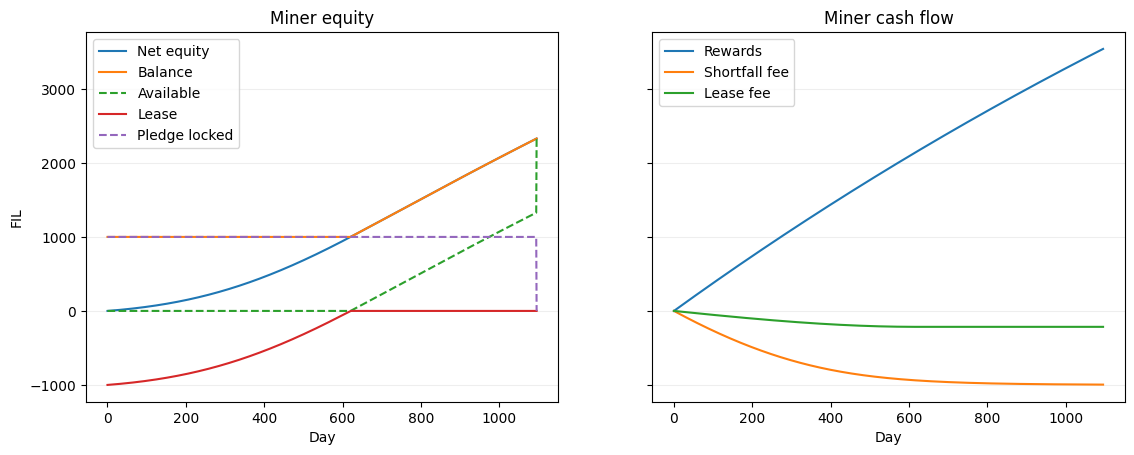

In [8]:
show_miner_accounting_charts(burn_shortfall_df)

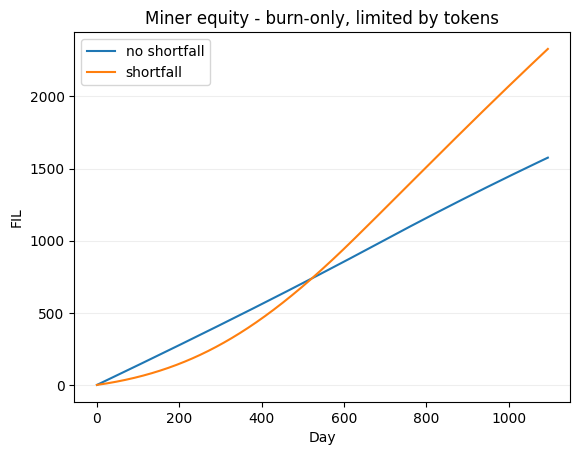

In [9]:
# Configurations limited by token availability.
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, False),
        miner_factory=BurnShortfallMinerState.factory(balance=0),
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
        miner_factory=BurnShortfallMinerState.factory(balance=0),
    )
}, 'burn-only, limited by tokens')


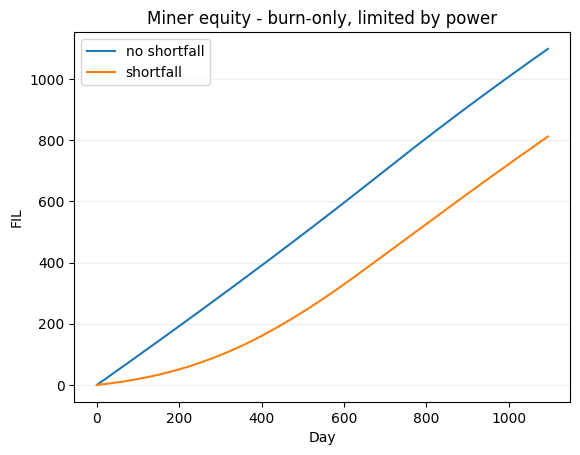

In [10]:
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100 * TIBIBYTE, 3 * YEAR, False),
        miner_factory=BurnShortfallMinerState.factory(balance=0),
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100 * TIBIBYTE, 3 * YEAR, True),
        miner_factory=BurnShortfallMinerState.factory(balance=0),
    )
}, 'burn-only, limited by power')
